In [1]:
import math
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

t.manual_seed(1)

In [2]:
class RNNcell(nn.Module):
    # y is the hidden state: hidden of shape (batch, hidden_size)
    # input of shape (batch, input_size): tensor containing input features
    # format as torch.nn.RNNCell in Pytorch
    def __init__(self, x_i_size, h_i_size):
        super(RNNcell,self).__init__()
        self.linearX = nn.Linear(x_i_size, h_i_size)
        self.linearA = nn.Linear(h_i_size, h_i_size)
        self.linearA1 = nn.Linear(h_i_size, h_i_size)
        #self.m = nn.Softmax(dim = 1)
        
    def forward(self, x_t, a_prev):
        a_t = F.tanh(self.linearX(x_t) + self.linearA(a_prev))
        #y_t = self.m(self.linearA1(a_t))
        return a_t
    
        

In [37]:
# Key class defined in this file 
class LSTMcell(nn.Module):
    def __init__(self, x_i_size, h_i_size):
        super(LSTMcell, self).__init__()
        
        self.linear_i_1 = nn.Linear(x_i_size, h_i_size, bias=True)
        self.linear_i_2 = nn.Linear(h_i_size, h_i_size, bias=True)
        
        self.linear_f_1 = nn.Linear(x_i_size, h_i_size, bias=True)
        self.linear_f_2 = nn.Linear(h_i_size, h_i_size, bias=True)
        
        self.linear_g_1 = nn.Linear(x_i_size, h_i_size, bias=True)
        self.linear_g_2 = nn.Linear(h_i_size, h_i_size, bias=True)  
        
        self.linear_o_1 = nn.Linear(x_i_size, h_i_size, bias=True)
        self.linear_o_2 = nn.Linear(h_i_size, h_i_size, bias=True)
        
    def forward(self, x_t, c_prev, h_prev):
        
        
        i = F.sigmoid(self.linear_i_1(x_t) + self.linear_i_2(h_prev))
        f = F.sigmoid(self.linear_f_1(x_t) + self.linear_f_2(h_prev))
        g = F.tanh(self.linear_g_1(x_t) + self.linear_g_2(h_prev))
        o = F.sigmoid(self.linear_o_1(x_t) + self.linear_o_2(h_prev))
        
        c_t = t.mul(f, c_prev) + t.mul(i, g)
        h_t = t.mul(o, F.tanh(c_t))
        
        return c_t, h_t
    

In [38]:
# test code for format
t.manual_seed(2)
rnn = LSTMcell(10, 20)
input = t.randn(6, 3, 10)
hx = t.randn(3, 20)
cx = t.randn(3, 20)
output = []
for i in range(6):
    cx, hx = rnn(input[i], cx, hx)
    output.append(hx)

In [39]:
output[0].shape

torch.Size([3, 20])

Test with case: time series 1 dimension. 
The test code is from the book "Learn Deep Learning with PyTorch" Chapiter 5, with modification 

In [40]:
data_csv = pd.read_csv('./data.csv', usecols=[1])

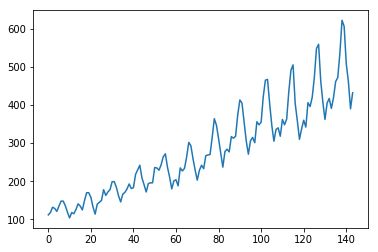

In [41]:
#original time seirs
plt.plot(data_csv)

In [42]:
# preprocessing
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [43]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [44]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = LSTMcell(input_size, hidden_size) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 
        
    def forward(self, x):
        c_prev = t.rand(1,self.hidden_size)
        h_prev = t.rand(1,self.hidden_size)
        x, _ = self.rnn(x, c_prev, h_prev) # (seq, batch, hidden), modification is here for my own class
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [45]:
# input and output 
data_X, data_Y = create_dataset(dataset)

In [46]:
# dataset for training and test，70% for training
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [47]:
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

In [48]:
net = lstm_reg(2, 4)

criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(), lr=1e-2)

In [49]:
for e in range(1000):
    # forward 
    out = net(train_x)
    loss = criterion(out, train_y)
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: 
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

C:\ProgramData\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


Epoch: 100, Loss: 0.04183
Epoch: 200, Loss: 0.02520
Epoch: 300, Loss: 0.00918
Epoch: 400, Loss: 0.00740
Epoch: 500, Loss: 0.00576
Epoch: 600, Loss: 0.00312
Epoch: 700, Loss: 0.00301
Epoch: 800, Loss: 0.00313
Epoch: 900, Loss: 0.00390
Epoch: 1000, Loss: 0.00347


In [50]:
net = net.eval()

In [51]:
data_X = data_X.reshape(-1, 1, 2)
data_X = t.from_numpy(data_X)

pred_test = net(data_X) 

In [52]:
pred_test = pred_test.view(-1).data.numpy()

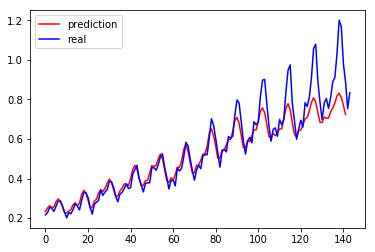

In [53]:
# compare the results 
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')